In [3]:
# from jupyterthemes import jtplot
# from jupyterthemes.stylefx import set_nb_theme
# currently installed theme will be used to
# set plot style if no arguments provided
# jtplot.style('solarizedl')
# set_nb_theme('solarizedl')

# from matplotlib import rcParams
#rcParams['figure.figsize'] = (22,5) # doesnt work inline, causes headache otherwise

# Outline of Part 2, Analysis of sorted spikes 

## 1) Set up, paths
## 2) Functions - easier than you think!
## 3) Load and inspect spikes
### a) Spike time raster 
### b) Binned raster
==========================================================================
### c) Zero in on a feature of data
## 4) Peristimulus time histogram

In [ ]:
# @title Helper functions
import os

import pandas as pd
from tqdm import tqdm
import xarray as xr
import requests
from pathlib import Path
import zipfile


def download_data():
    # Get link:
    r = requests.get('http://data.cortexlab.net/singlePhase3/data/dataset.zip')
    path = Path('data/dataset.zip')
    path.parent.mkdir(exist_ok=True)
    with open(path, "wb") as fid:
        # Write out content of link:
        fid.write(r.content)
    # Unzip
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(path.parent)


def load_spikes_from_phy(path_to_data='/Users/myroshnychenkm2/Downloads/dataset/', sampling_frequency=30000):
    """
    Get spikes from a kilosort/phy result folder
    :param path_to_data:
    :param sampling_frequency:
    :return: 
    :id: neuron id, 1xN
    :ts: corresponding spiketime, 1xN
    """
    groupfname = os.path.join(path_to_data, 'cluster_groups.csv')
    groups = pd.read_csv(groupfname, delimiter='\t')

    # load spike times and cluster IDs
    with open(path_to_data + 'spike_clusters.npy', 'rb') as f:
        ids = np.load(f).flatten()
    with open(path_to_data + 'spike_times.npy', 'rb') as f:
        ts = np.load(f).flatten()

    # Create the list of our "good" labeled units
    ids_to_take = groups[(groups.group == 'good')].cluster_id
    # Find which spikes beloing to our "good" groups
    spikes_to_take = []
    for i in tqdm(ids_to_take, desc='Selecting only good spikes'):
        spikes_to_take.extend((ids == i).nonzero()[0])
    # only take spikes that are in our list
    ids = np.array(ids[spikes_to_take])
    ts = np.array(ts[spikes_to_take]).astype(float) / sampling_frequency

    return ids, ts


def bin_neuron(spike_times, bin_size=.100, window=None):
    """
    Make binned raster for a single neuron
    :param spike_times:
    :param bin_size: in sec
    :param window:
    :return:
    """
    if window is None:
        window = [0, spike_times.max()]
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    return np.histogram(spike_times, bins)[0]


def bin_neurons(spike_times, neuron_ids, bin_size=None, window=None, plotose=False):
    """
    Make binned raster for many neurons
    :param spike_times:
    :param neuron_ids:
    :param bin_size: in sec
    :param window:
    :param plotose:
    :return:
    """
    if window is None:
        window = [0, spike_times.max()]
    # the following uses an inline for loop (look it up):
    spike_counts = [bin_neuron(spike_times[neuron_ids == neuron_id], bin_size, window)
                    for neuron_id in tqdm(np.unique(neuron_ids))]
    spike_counts = np.vstack(spike_counts)
    raster = xr.DataArray(spike_counts, coords=dict(Time=np.arange(window[0], window[1] + bin_size, bin_size)[:-1],
                                                    Single_unit_id=range(len(np.unique(neuron_ids)))),
                          dims=['Single_unit_id', 'Time'])
    if plotose:
        raster.plot(robust=True)
    return raster


def identify_down_states(ts, bin_size=.05, number_of_neurons_treshold=20, minimum_time_between_states=0.15):
    """
    Find spontaneous periods of quiecence in spiketimes
    :param ts:
    :param bin_size:
    :param number_of_neurons_treshold:
    :param minimum_time_between_states:
    :return:
    """
    lfp = bin_neuron(np.sort(ts), bin_size=bin_size)
    down_states = np.where(lfp < number_of_neurons_treshold)[0]
    down_states_lengths = np.diff(down_states)
    print(f'Eliminating {down_states[1:][down_states_lengths < .15 / bin_size].shape} that are too short')
    down_states = down_states[1:][down_states_lengths > minimum_time_between_states / bin_size]
    print(f'Ended up with {down_states.shape} down states')
    # convert into seconds:
    down_states = down_states * bin_size
    down_states -= .03
    print(down_states[(down_states > 63) & (down_states < 68)])  # compare with raster
    return lfp, down_states


class PSTH:
    """
    A collection of functions dealing with peristimulus time histogram
    """

    @staticmethod
    def make_psth(trial_starts):
        """
        Simple wrapper creating a dataframe with times we want to lock onto
        :param trial_starts: List of times of interest (trials)
        :return: spykes object
        """
        trials = pd.DataFrame()
        trials['trialStart'] = trial_starts
        return trials

    @staticmethod
    def spykes_get_times(s_ts, s_id, debug=False):
        """
        Use spykes library
        :param s_ts:
        :param s_id:
        :param debug:
        :return:
        """

        def print_spyke(spykess):
            [print(len(spykess[i].spiketimes)) for i in range(len(spykess))]

        from spykes.plot import neurovis
        s_id = s_id.astype('int')
        neuron_list = list()
        for iu in np.unique(s_id):
            spike_times = s_ts[s_id == iu]
            if len(spike_times) < 2:
                if debug:
                    print('Too few spiketimes in this unit: ' + str(spike_times))
                else:
                    pass  # neuron_list.append(NeuroVis([],'ram'+str(iu)))
            else:
                neuron = neurovis.NeuroVis(spike_times, name='ram' + str(iu))
                neuron_list.append(neuron)

        if debug:
            print_spyke(neuron_list)
        return neuron_list

    @staticmethod
    def spykes_summary(spikes, spykes_df, event, window=[-100, 100], bin_size=10, fr_thr=.1, plotose=True):
        """

        :param spikes:
        :param spykes_df:
        :param event:
        :param window:
        :param bin_size:
        :param fr_thr:
        :param plotose:
        :return:
        """
        import spykes
        assert window[1] - window[0] > 0, 'Window size must be greater than zero!'
        # filter firing rate
        spikes = [i for i in spikes if i.firingrate > fr_thr]
        pop = spykes.plot.popvis.PopVis(spikes)
        # calculate psth
        mean_psth = pop.get_all_psth(event=event, df=spykes_df, window=window, binsize=bin_size, plot=False)
        assert mean_psth['data'][0].size > 0, 'Empty group PSTH!'
        if plotose:
            # % plot heatmap of average psth
            _ = plt.figure(figsize=(10, 10))
            #        fig.subplots_adjust(hspace=.3)
            # set_trace()
            pop.plot_heat_map(mean_psth, sortby=None, sortorder='ascend', normalize=None,
                              colors=['viridis'])  # or latency

            # %% Population PSTH
            plt.figure()
            pop.plot_population_psth(all_psth=mean_psth, event_name='Event',
                                     colors=([.5, .5, .5], [0, .6, 0]))

        return pop, mean_psth



In [1]:
# Import basic libraries 
!pip install matplotlib pandas xarray numpy tqdm spykes
import matplotlib.pylab as plt, numpy as np,tqdm

download_data()

In [4]:
neuron_ids_huge, spike_times_all_neurons_huge =load_spikes_from_phy('data/')

Selecting only good spikes: 100%|██████████| 242/242 [00:03<00:00, 78.39it/s]


# Housekeeping detour
## Inspecting variables
## Inspecting functions 

# Visualizing spiketimes without binning 

In [5]:
# Let's inspect the spikes
print(neuron_ids_huge)
print(spike_times_all_neurons_huge)

[  13   13   13 ... 1209 1209 1209]
[  10.07096667   32.3822       46.20356667 ... 3773.10953333 3773.46326667
 3773.48606667]


# What are the sizes of each of these variables?

In [6]:
# Limit the number of spikes we're dealing with but keep full variables
neuron_ids = neuron_ids_huge[spike_times_all_neurons_huge<70]
spike_times_all_neurons = spike_times_all_neurons_huge[spike_times_all_neurons_huge<70]

In [7]:
# Let's inspect the timestamps from one neuron
id_of_interest = neuron_ids[300]
spike_times_of_interest=spike_times_all_neurons[neuron_ids == id_of_interest]
print(spike_times_of_interest)

[ 0.1449      0.24753333  0.46693333  0.62893333  0.65033333  1.21656667
  1.2314      1.2845      1.77893333  1.78703333  2.06783333  2.25276667
  2.26203333  2.3779      3.0921      3.11793333  3.12776667  3.13796667
  3.75693333  3.7698      4.6546      4.7072      4.71426667  4.80536667
  4.85086667  4.9817      4.98783333  5.06946667  5.33776667  6.07223333
  6.08506667  6.2339      7.34353333  7.55986667  8.1842      8.192
  8.2121      8.52053333  8.52916667  9.02863333  9.04153333  9.0639
  9.29206667  9.30023333  9.5331      9.55053333 10.061      10.0732
 10.3263     10.33643333 10.8437     11.17213333 11.46903333 11.65286667
 11.68153333 11.6925     11.72723333 11.83643333 11.8486     11.8821
 11.94126667 11.97043333 12.16116667 12.23776667 12.25543333 13.04003333
 13.17443333 13.27843333 13.2862     13.29753333 13.40853333 13.42433333
 13.6446     13.6625     13.74406667 13.75823333 14.16746667 14.18983333
 14.36326667 14.36953333 14.39746667 14.4203     14.45683333 14.6590

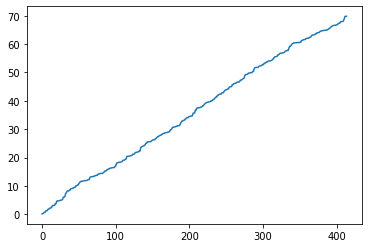

In [8]:
# Plot spiketimes
plt.plot(spike_times_of_interest)


## What are neurons' identities in this plot? 
## Why is the curve progressively rising?
## What's on the x- and y- axes?


Text(0.5, 0, 'Number of spikes')

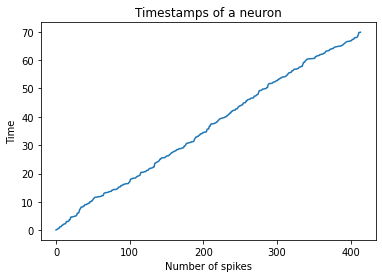

In [9]:
# Let's inspect the timestamps from one neuron - version 2
plt.plot(spike_times_of_interest)
plt.title('Timestamps of a neuron')
plt.ylabel('Time')
plt.xlabel('Number of spikes')


 What is a plot like this good for? (Hint: what would the change in firing rate look like?)

# Visualizing raster of spiketimes 

In [10]:
# Raster of one neuron, by hand
plt.xlim([0, spike_times_of_interest.max()])
for ... in ...:
    plt.scatter(x=this_timestamp, y=1,marker='|',color='black')
    plt.show()
    plt.pause(.01)

SyntaxError: can't assign to Ellipsis (<ipython-input-10-54ea46ce624b>, line 3)

This is our first For loop! How does it work?


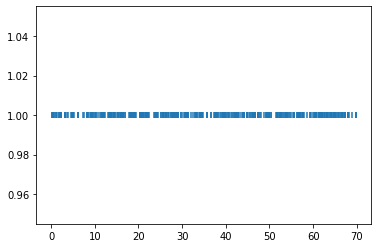

In [14]:
# Whole raster for one neuron, no loop 
# %matplotlib tk # slide housekeeping, nothing to see here
plt.scatter(x=spike_times_of_interest,
            y=np.ones(spike_times_of_interest.shape[0]),
            marker='|')



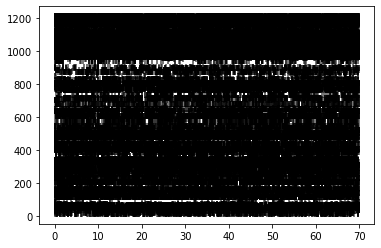

In [15]:
# For all neurons now
plt.scatter(x=spike_times_all_neurons,
            y=neuron_ids,
            marker='|', c='k', alpha=.7)




# visualizing binned raster 


In [17]:
# Use my function with xarray
raster = bin_neurons(spike_times_all_neurons, neuron_ids, bin_size=.05)
print(raster) # xarray

100%|██████████| 238/238 [00:00<00:00, 5088.02it/s]

<xarray.DataArray (Single_unit_id: 238, Time: 1400)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [2, 0, 1, ..., 0, 0, 0],
       [2, 0, 1, ..., 1, 1, 2],
       [0, 1, 2, ..., 0, 0, 0]])
Coordinates:
  * Time            (Time) float64 0.0 0.05 0.1 0.15 ... 69.8 69.85 69.9 69.95
  * Single_unit_id  (Single_unit_id) int64 0 1 2 3 4 5 ... 233 234 235 236 237


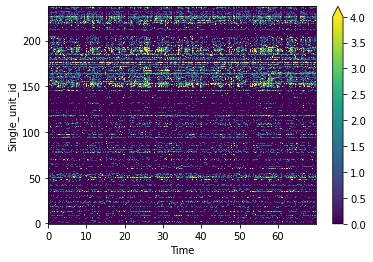

In [19]:
raster.plot(robust=True);
# plt.show()

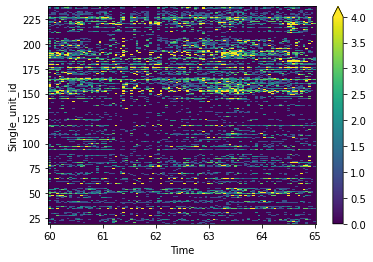

In [20]:
# Convenient one-liners to "slice" the raster by time or neurons
raster.sel(Single_unit_id=slice(20,1200), Time=slice(60,65)).plot(robust=True);
## Do you see the difference? We are missing-ish the up states

In [21]:
# PSTH
lfp, down_states = identify_down_states(spike_times_all_neurons_huge)

Eliminating (9,) that are too short
Ended up with (142,) down states
[]


100%|██████████| 142/142 [00:00<00:00, 1052.99it/s]


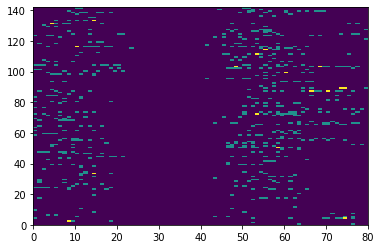

In [22]:
# PSTH based on homemade code
raster = bin_neurons(spike_times_all_neurons_huge, neuron_ids_huge, bin_size=.005)
psth=[]
for down_state in tqdm.tqdm(down_states):
    # get raster
    raster_now=raster.sel(Time=slice(down_state-.100,
                                     down_state+.300))
    # add raster to psth
    psth.append(raster_now.sel(Single_unit_id=241).values[:80]) # Note no equals sign
psth_all=np.vstack(psth)
# With for loop as the basic building block, you can do anything!
## plot psth
plt.pcolormesh(psth_all);
## Q: What are the axes?

NameError: name 'pdf' is not defined

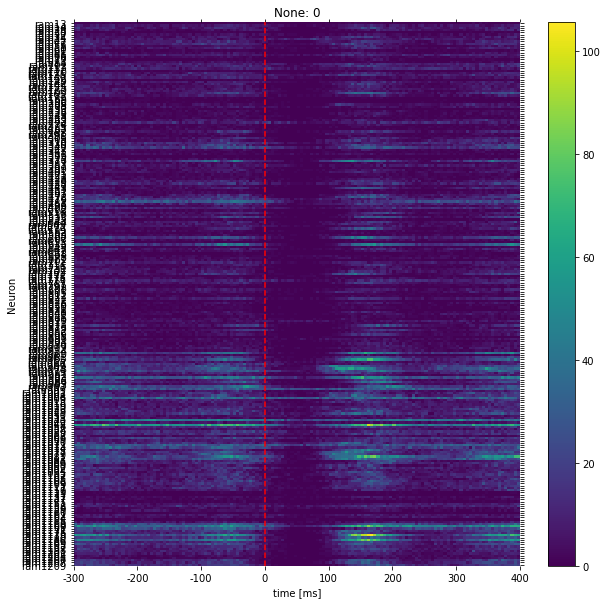

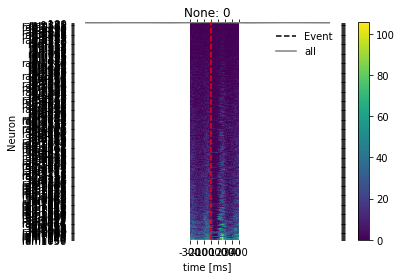

In [23]:
# ============= Kording psth toolbox is a lot easier ===============
# make a psth object using the toolbox:
psth_object = PSTH.make_psth(down_states)
# make raster using toolbox:
spykes_times = PSTH.spykes_get_times(spike_times_all_neurons_huge, neuron_ids_huge)
# Get mean PSTH for all neurons
pop, all_psth = PSTH.spykes_summary(spikes=spykes_times, spykes_df=psth_object, 
                                               event='trialStart', window=[-300, 400], bin_size=5, plotose=True)
# Plot mean PSTH for all neurons
pop.plot_heat_map(all_psth, sortby='rate', sortorder='ascend', normalize=None, colors=['viridis'])  # or latency
## Note the periodicity
## Q: Do you think if you flip the detection, the result will be similar and opposite? Hint: Inspect the raster.
# Test your hypothesis by setting down_states = np.where(lfp > 90)[0]